In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount("/content/drive/")


Mounted at /content/drive/


In [60]:
data = pd.read_csv("/content/drive/My Drive/PF/WORKEY/NY-House-Dataset.csv", encoding='latin1')
data

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.000000,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.000000,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.000000,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.000000,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.000000,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,Brokered by COMPASS,Co-op for sale,599000,1,1.000000,2184.207862,222 E 80th St Apt 3A,"Manhattan, NY 10075","222 E 80th St Apt 3AManhattan, NY 10075",New York,New York County,New York,Manhattan,222,"222 E 80th St #3a, New York, NY 10075, USA",40.774350,-73.955879
4797,Brokered by Mjr Real Estate Llc,Co-op for sale,245000,1,1.000000,2184.207862,97-40 62 Dr Unit Lg,"Rego Park, NY 11374","97-40 62 Dr Unit LgRego Park, NY 11374",United States,New York,Queens County,Queens,62nd Drive,"97-40 62nd Dr, Rego Park, NY 11374, USA",40.732538,-73.860152
4798,Brokered by Douglas Elliman - 575 Madison Ave,Co-op for sale,1275000,1,1.000000,2184.207862,427 W 21st St Unit Garden,"New York, NY 10011","427 W 21st St Unit GardenNew York, NY 10011",United States,New York,New York County,New York,West 21st Street,"427 W 21st St, New York, NY 10011, USA",40.745882,-74.003398
4799,Brokered by E Realty International Corp,Condo for sale,598125,2,1.000000,655.000000,91-23 Corona Ave Unit 4G,"Elmhurst, NY 11373","91-23 Corona Ave Unit 4GElmhurst, NY 11373",New York,Queens County,Queens,Flushing,91-23,"91-23 Corona Ave. #4b, Flushing, NY 11373, USA",40.742770,-73.872752


## Select Relevant Columns and Extract ZIP Code

The original dataset contains detailed location information and text-based descriptions not needed for modeling.

We’ll:
- Keep only key numeric features and geographic identifiers
- Extract the ZIP code from the `STATE` column, which currently includes city and ZIP code
- Drop all columns unrelated to modeling (text-heavy address columns, titles, etc.)


In [61]:
columns_to_keep = ['TYPE', 'PRICE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'STATE']
data = data[columns_to_keep].copy()


data['ZIPCODE']= data['STATE'].str.extract(r'(\d{5})')  # Extract 5-digit ZIP

data.drop(columns=['STATE'], inplace=True)

data

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ZIPCODE
0,Condo for sale,315000,2,2.000000,1400.000000,10022
1,Condo for sale,195000000,7,10.000000,17545.000000,10019
2,House for sale,260000,4,2.000000,2015.000000,10312
3,Condo for sale,69000,3,1.000000,445.000000,10022
4,Townhouse for sale,55000000,7,2.373861,14175.000000,10065
...,...,...,...,...,...,...
4796,Co-op for sale,599000,1,1.000000,2184.207862,10075
4797,Co-op for sale,245000,1,1.000000,2184.207862,11374
4798,Co-op for sale,1275000,1,1.000000,2184.207862,10011
4799,Condo for sale,598125,2,1.000000,655.000000,11373


In [62]:
print(data['TYPE'].value_counts())

TYPE
Co-op for sale                1450
House for sale                1012
Condo for sale                 891
Multi-family home for sale     727
Townhouse for sale             299
Pending                        243
Contingent                      88
Land for sale                   49
For sale                        20
Foreclosure                     14
Condop for sale                  5
Coming Soon                      2
Mobile house for sale            1
Name: count, dtype: int64


## Filter Property Types to Housing-Only Listings

We focus the dataset on actual residential housing types and exclude:
- Non-residential or ambiguous listings (e.g., land, foreclosure, mobile)
- Transactional states (e.g., pending, contingent)

Also remove the for sale and correct the spelling of `Condop` to `Condo`

Filtered types retained:
- House
- Townhouse
- Multi-family home
- Condo
- Co-op


In [63]:
valid_types = [
    'House for sale',
    'Townhouse for sale',
    'Multi-family home for sale',
    'Condo for sale',
    'Condop for sale',
    'Co-op for sale'
]

data = data[data['TYPE'].isin(valid_types)].copy()

data.reset_index(drop=True, inplace=True)

data['TYPE'] = data['TYPE'].apply(lambda x:
    'House' if x == 'House for sale' else
    'Townhouse' if x == 'Townhouse for sale' else
    'Multi-family home' if x == 'Multi-family home for sale' else
    'Condo' if x == 'Condo for sale' else
    'Condo' if x == 'Condop for sale' else
    'Co-op' if x == 'Co-op for sale' else
    x
)

print(data['TYPE'].value_counts())

TYPE
Co-op                1450
House                1012
Condo                 896
Multi-family home     727
Townhouse             299
Name: count, dtype: int64


## Exploratory Data Visualization

This section explores the distribution and relationship between housing features and sale price. Specifically, we:

- Examine price distribution and outliers
- Understand how property size impacts price
- Compare average pricing across different housing types


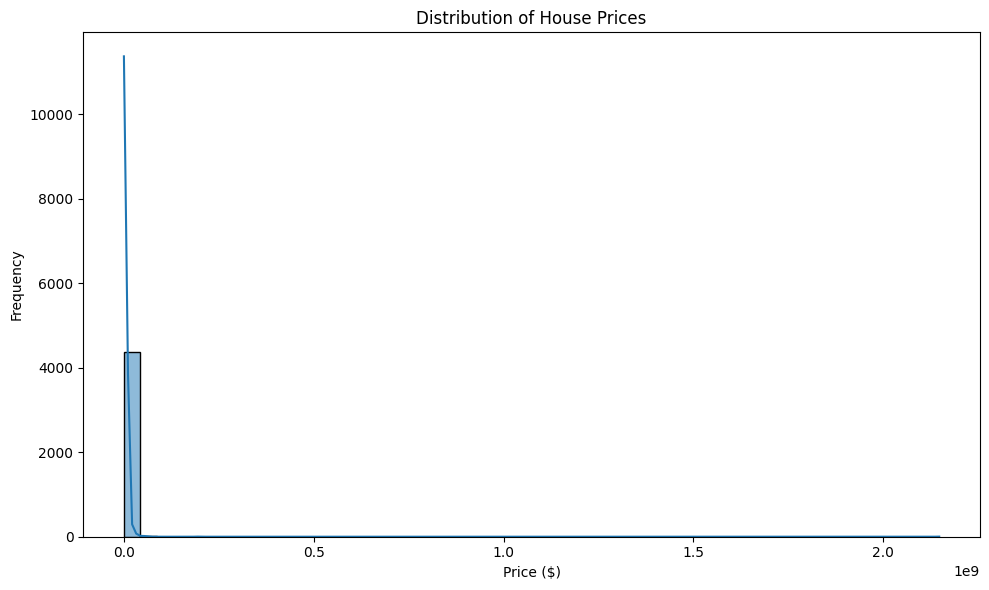

In [65]:
plt.figure(figsize=(10, 6))


sns.histplot(data['PRICE'], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

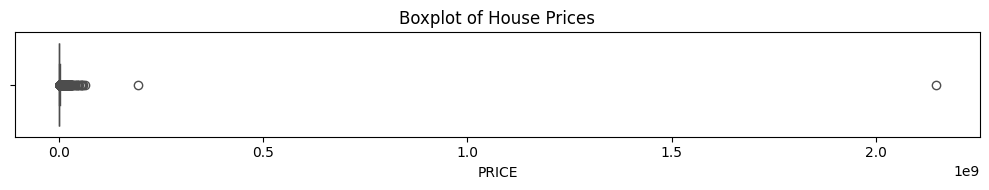

In [66]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=data['PRICE'], color="blue")
plt.title("Boxplot of House Prices")
plt.tight_layout()
plt.show()

## This charts shows that there is one outlier values which seems to be error

In [71]:
data.sort_values(by='PRICE', ascending=False).head(10)

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ZIPCODE
275,House,2147483647,7,6.000000,10000.000000,10309
1,Condo,195000000,7,10.000000,17545.000000,10019
67,Townhouse,65000000,3,2.373861,15200.000000,10075
953,Co-op,60000000,8,8.000000,2184.207862,10075
126,House,56000000,11,10.000000,24000.000000,10019
91,House,55000000,8,8.000000,12000.000000,10023
4,Townhouse,55000000,7,2.373861,14175.000000,10065
531,Condo,50000000,6,6.000000,6569.000000,10013
1304,Co-op,48000000,5,2.373861,2184.207862,10021
3077,Co-op,45000000,5,2.373861,2184.207862,10065


## Remove Erroneous Price Value (Integer Overflow) and visualize again

The value `2147483647` and `195000000` in the `PRICE` column are likely placeholder overflow or error.

We'll remove just that one record, while preserving valid high-end listings.


In [76]:
data = data[data['PRICE'] != 2147483647].copy()
data = data[data['PRICE'] != 195000000].copy()
data.reset_index(drop=True, inplace=True)

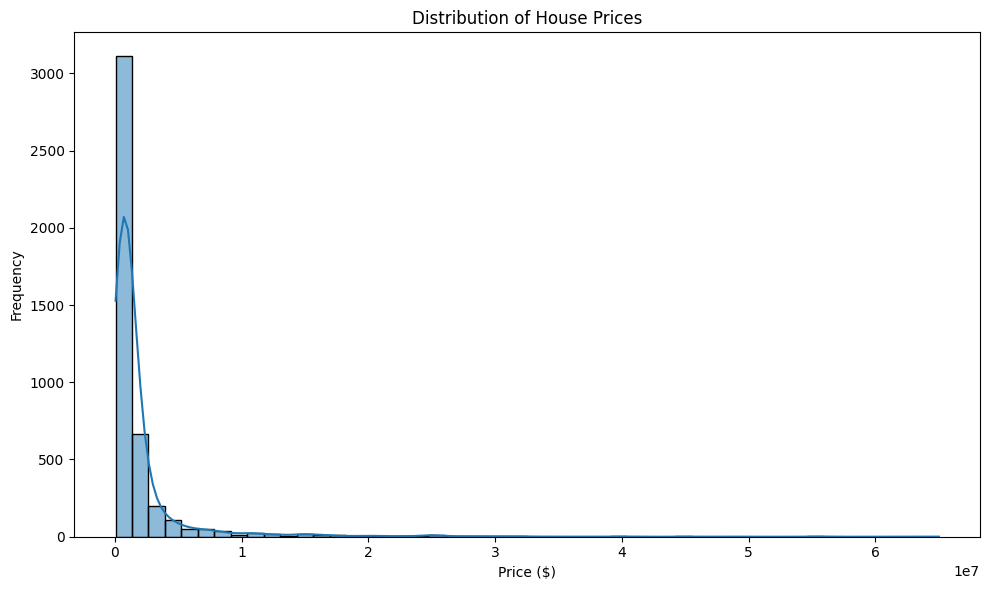

In [78]:
plt.figure(figsize=(10, 6))


sns.histplot(data['PRICE'], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

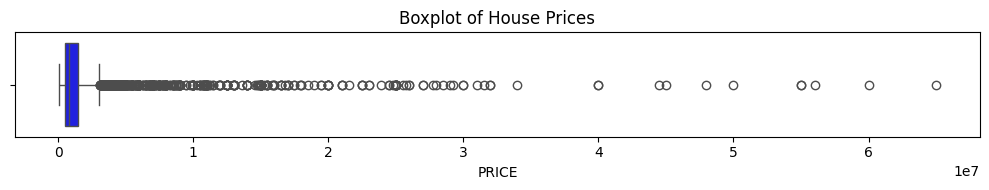

In [79]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=data['PRICE'], color="blue")
plt.title("Boxplot of House Prices")
plt.tight_layout()
plt.show()

### Analysis Distribution plots

These two plots—a histogram and a boxplot—visualize the distribution of the `PRICE` variable. Both charts clearly and consistently show that the price data is heavily skewed.


#### 1. The Histogram (Top Plot)

*   **Shape and Skew:** The histogram displays a pronounced **positive (or right) skew**. The vast majority of the data is clustered on the far left, with a tall peak indicating a high frequency of properties at lower prices. The distribution then stretches out into a long, flat tail to the right.

*   **Peak Frequency:** The most frequent price range (the mode) is in the first bin, with a frequency of over 3,000 listings. This shows that most houses are concentrated at the low end of the price scale.

*   **The Long Tail:** The tail extends significantly to the right, with prices reaching up to approximately $65,000,000 (as the x-axis is scaled by `1e7`). This long tail is formed by a small number of very expensive properties that are not typical of the overall market.


#### 2. The Boxplot (Bottom Plot)

The boxplot confirms the observations from the histogram with a statistical summary:

*   **The Box (Interquartile Range - IQR):** The blue box, which contains the middle 50% of the data, is very short and compressed on the far left. This visually demonstrates that half of all properties are clustered within a narrow, low-price band.

*   **The Median:** The vertical line inside the box represents the **median** price. Its position at a very low value confirms that the "typical" house price is modest compared to the full range of prices.

*   **Outliers:** The most prominent feature is the large stream of individual circles stretching far to the right. These are **outliers**, representing the exceptionally high-priced homes that create the long tail in the histogram. The sheer number and range of these outliers are the primary cause of the data's skew.



### Key Takeaways & Conclusions

*   **Skewed Market:** The housing market represented by this data is not normally distributed. It consists of a large volume of lower-priced homes and a small number of high-priced luxury properties.

*   **Median Over Mean:** Due to the strong right skew, the **mean (average) price will be significantly inflated** by the high-value outliers. The **median** is a much more robust and representative measure of the central tendency for this dataset.

*   **Implications for Modeling:** If you plan to use this `PRICE` variable as a target in a predictive model, its skewed nature should be addressed. Applying a **logarithmic transformation** (`np.log1p`) to the price data is a standard and effective technique to make the distribution more symmetrical, which often improves the performance of many machine learning algorithms.

/tmp/ipython-input-80-2214144418.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_by_type.index, y=avg_price_by_type.values, palette="Set2")


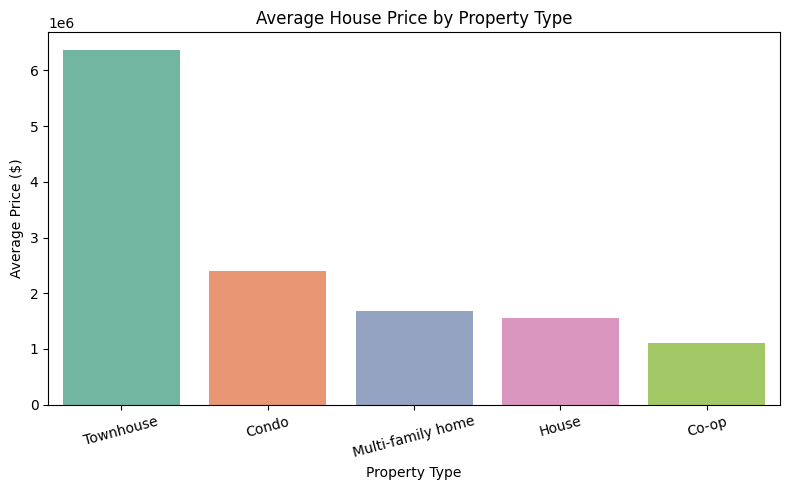

In [80]:
plt.figure(figsize=(8, 5))
avg_price_by_type = data.groupby('TYPE')['PRICE'].mean().sort_values(ascending=False)

sns.barplot(x=avg_price_by_type.index, y=avg_price_by_type.values, palette="Set2")
plt.title("Average House Price by Property Type")
plt.ylabel("Average Price ($)")
plt.xlabel("Property Type")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Analysis of Average House Price by Property Type

This bar chart compares the average price across five different property types. The y-axis represents the average price in millions of dollars (as indicated by the `1e6` notation).



#### Detailed Observations

The chart shows a clear difference in the average price depending on the type of property:

*   **Townhouse:** This is by far the most expensive category, with an average price of approximately **$6.3 million**. It is more than twice as expensive as the next highest category.

*   **Condo:** The second most expensive property type, with an average price of around **$2.4 million**.

*   **Multi-family home:** Ranks third, with an average price of approximately **$1.7 million**.

*   **House:** This category has an average price of about **$1.5 million**, making it slightly less expensive on average than a Multi-family home.

*   **Co-op:** This is the least expensive property type, with an average price of just over **$1.1 million**.



### Key Takeaways & Conclusions

1.  **Clear Price Hierarchy:** There is a distinct pricing hierarchy among property types, with Townhouses commanding a significant premium over all other categories.

2.  **Townhouses Dominate:** Townhouses are the clear outliers in terms of average price, suggesting they may represent a luxury segment of the market in this dataset.

3.  **Co-ops as the Most Affordable:** Co-ops are, on average, the most affordable entry point into this housing market.

#### Important Note on Averages

Given that we previously saw the overall price distribution is **heavily right-skewed**, using the **mean (average)** price can be misleading. A few extremely expensive properties within a category (especially "Townhouse") could be inflating the average for that group.

For a more robust comparison, it would be highly beneficial to also create a similar bar chart using the **median** price for each property type. This would provide a better sense of the "typical" price and confirm if the same pricing hierarchy holds true.

## Apply Log Transformation to Target Variable

The original `listPrice` distribution is highly skewed to the right, with many extreme outliers at the upper end. To normalize the target variable and improve model performance, we apply a **logarithmic transformation**.

This reduces the impact of high-end outliers and ensures better assumptions for linear modeling.


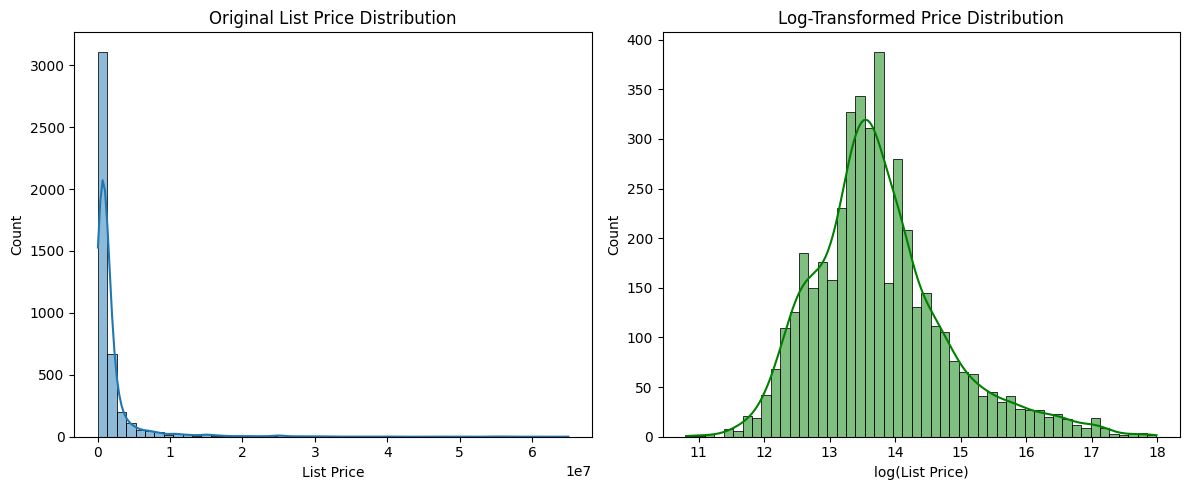

In [81]:
data['log_price'] = np.log1p(data['PRICE'])  # log1p = log(1 + x) to handle 0 values


plt.figure(figsize=(12, 5))

# Original distribution
plt.subplot(1, 2, 1)
sns.histplot(data['PRICE'], bins=50, kde=True)
plt.title("Original List Price Distribution")
plt.xlabel("List Price")

# Log-transformed distribution
plt.subplot(1, 2, 2)
sns.histplot(data['log_price'], bins=50, kde=True, color='green')
plt.title("Log-Transformed Price Distribution")
plt.xlabel("log(List Price)")

plt.tight_layout()
plt.show()



## The logarithmic transformation was highly effective at neutralizing the extreme right-skew of the original price data resulting distribution that is much closer to a normal distribution.

In [83]:
data.isnull().sum()

,0
TYPE,0
PRICE,0
BEDS,0
BATH,0
PROPERTYSQFT,0
ZIPCODE,0
log_price,0


## no missing values. we are good

In [84]:
data

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ZIPCODE,log_price
0,Condo,315000,2,2.000000,1400.000000,10022,12.660331
1,House,260000,4,2.000000,2015.000000,10312,12.468441
2,Condo,69000,3,1.000000,445.000000,10022,11.141876
3,Townhouse,55000000,7,2.373861,14175.000000,10065,17.822844
4,House,690000,5,2.000000,4004.000000,11238,13.444448
...,...,...,...,...,...,...,...
4377,Co-op,599000,1,1.000000,2184.207862,10075,13.303019
4378,Co-op,245000,1,1.000000,2184.207862,11374,12.409018
4379,Co-op,1275000,1,1.000000,2184.207862,10011,14.058458
4380,Condo,598125,2,1.000000,655.000000,11373,13.301557


## Step 5: Feature Selection with ZIP Code

We now include `ZIPCODE` in our feature set to capture location-based variation in property pricing.

The selected features are:
- `PROPERTYSQFT`
- `BEDS`
- `BATH`
- `TYPE` (property type)
- `ZIPCODE` (location)

Categorical variables `TYPE` and `ZIPCODE` are encoded using one-hot encoding.



In [85]:
features = ['PROPERTYSQFT', 'BEDS', 'BATH', 'TYPE', 'ZIPCODE']
data_model = data[features + ['PRICE']].copy()

data_model['ZIPCODE'] = data_model['ZIPCODE'].astype(str)


data_model = pd.get_dummies(data_model, columns=['TYPE', 'ZIPCODE'], drop_first=True)

X = data_model.drop('PRICE', axis=1)
y = data_model['PRICE']


## Model Training and Evaluation

We now split the dataset into training and test sets using an 80/20 split.

A Random Forest Regressor is used for predicting house prices. Model performance is evaluated using:

- **Root Mean Squared Error (RMSE)**: measures average prediction error in dollars
- **R_squared Score**: indicates how much variance in house prices is explained by the model


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

rf_model = RandomForestRegressor(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" RMSE: ${rmse:,.2f}")
print(f" R_squared Score: {r2:.3f}")

 RMSE: $2,621,789.20
 R_squared Score: 0.559


## Visualize Actual vs Predicted Prices

This scatterplot compares predicted house prices to actual sale prices.

- Points on the diagonal line represent perfect predictions.
- Points below the line are **overestimated**.
- Points above the line are **underestimated**.

This helps assess prediction accuracy and detect bias in specific price ranges.


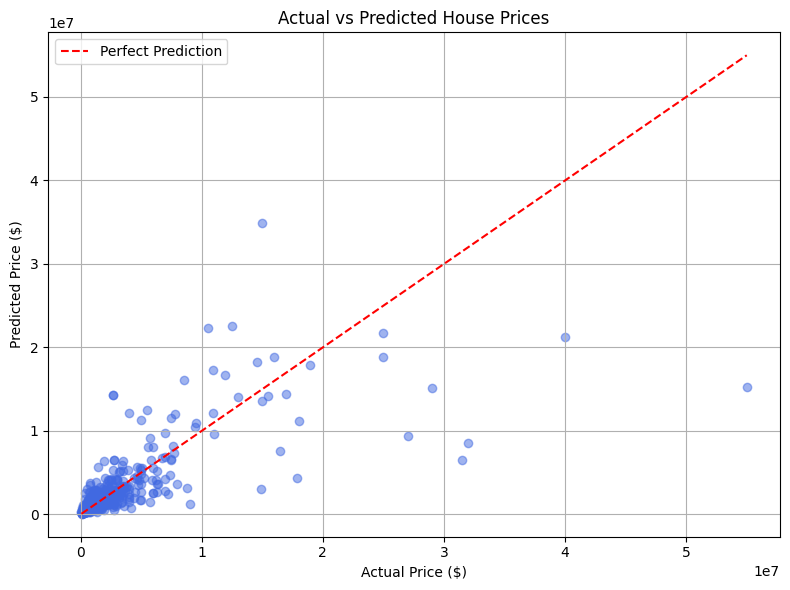

In [87]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         '--', color='red', label='Perfect Prediction')
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted House Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importance

This bar plot displays how much each feature contributes to the prediction of house prices.

- Higher importance = stronger influence on the model
- Helps identify whether `ZIPCODE`, `SQFT`, or `BEDS/BATHS` dominate the prediction


/tmp/ipython-input-88-621061857.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')


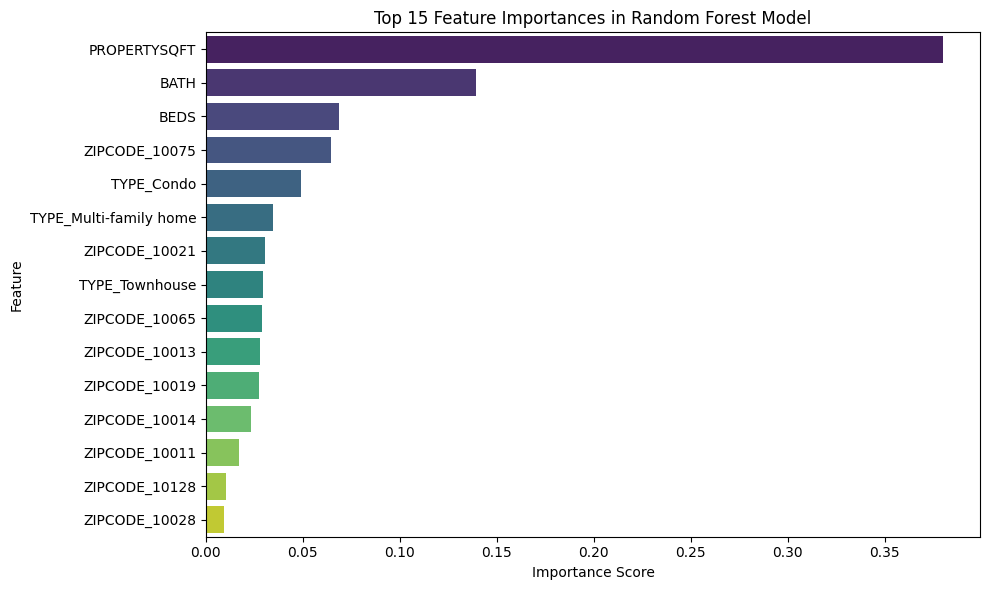

In [88]:
importances = rf_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Feature Importances in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()